# Domácí úkol č. 2 - 🕸 Síťová analýza PID

## 📚 Data
Jako dataset nám poslouží [otevřená data Pražské integrované dopravy](https://pid.cz/o-systemu/opendata/). Konkrétně budeme pracovat s daty [cestovních řádů](https://pid.cz/o-systemu/opendata/#h-gtfs), která jsou původně ve formátu GTFS (General Transit Feed Specification). To je formát, který využívá široká škála softwarových aplikací a kvůli tomu jej při publikaci dat využívají také veřejné dopravní agentury včetně PID.

☝️**Pozor!** Pro řešení domácí úlohy vám poskytneme už připravený dataset $D$ ve formátu `csv`. Dataset $D$ jsme pro vás sestavili z dat, která pocházejí z [cestovních řádů](https://pid.cz/o-systemu/opendata/#h-gtfs). Více informací o všech souborech a jejich atributech lze nalézt v [dokumentaci formátu GTFS](https://developers.google.com/transit/gtfs/reference).

## Zadání
> ☝️ Používejte markdown buňky! Zdůvodňujte všechny důležité kroky, popisujte vizualizace a co je z nich možné pozorovat. Za nepřehledný domácí úkol nebudou uděleny body.

Za řádné průběžné komentování a vizuální prezentaci postupu a výsledků lze získat až 4 body. Úkol řešíte jako **jednotlivci**.

**✨ Dataset**
* Načtěte si data ze souboru `d.csv`, což je již zmíněný dataset $D$, který obsahuje záznam pro každé dvě **po sobě jdoucí** zastávky nějakého spoje.
* Struktura je následující (pro zjednodušení neuvažujeme service start_date a end_date):
| stop_from | stop_from_name | stop_to | stop_to_name | depart_from | arrive_to | route_type | is_night | mon | tue | wed | thu | fri | sat | sun |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| U699Z3P | Stadion Strahov | U981Z1P | Koleje Strahov | 7:24:00 | 7:25:00 | 3 | 0 | 1 | 1 | 1 | 1 | 1 | 0 | 0 |

* Jedinečným identifikátorem zastávky je **název zastávky**. Pozor na stejné názvy zastávek pro různé dopravní prostředky - u takových zastávek uvažujte, že se jedná o jednu a tutéž stanici.


**🕸️ Základní síťová analýza** (celkem 12 bodů)

Úkolem je analyzovat síť zastávek PID. Zastávky tedy budou uzly sítě. Mezi dvěma zastávkami je orientovaná hrana, pokud jsou to dvě po sobě jdoucí zastávky nějakého spoje (existuje alespoň jeden záznam v datasetu $D$ s odpovídajícími `stop_from`, `stop_to`). Váha hrany je rovna počtu dopravních prostředků, které na dané trase za období jednoho týdne projedou.

Postupujte následovně:
* Začněte volbou libovolného balíčku pro analýzu a vizualizaci sítí (lze využít i zmíněný NetworkX),
* z datasetu $D$ vytvořte reprezentaci dat, která je vhodná pro vámi zvolený vizualizační balíček,
* vytvořte vizualizaci sítě (celkem za 4 body) - vizualizace musí být čitelná, proto můžete vizualizovat i podčást sítě (např. pro určitý dopravní prostředek, např. tramvaje (kromě vizualizace sítě lanovky nebo metra, tu neuznáváme) nebo nějaký podgraf - řešení ponecháme na vás),
* pomocí alespoň tří měr centrality analyzujte důležitost zastávek za období jednoho týdne (pondělí - neděle) a komentujte slovně, co tyto míry vzhledem ke konkrétním datům znamenají (každá míra za 2 body, celkem tedy za 6 bodů),
* vytvořte vizualizaci pro alespoň jednu míru centrality (celkem za 2 body).

**❓ Vlastní otázky** (3 body za každou otázku, celkem max. 9 bodů)

Vytvořte 3 otázky (můžete i více), založené na filtraci datasetu $D$ a odpovídejte na ně vhodnými vizualizacemi. Otázky pro inspiraci:
* Mění se důležité zastávky v závislosti na denním/nočním provozu?
* Je rozdíl ve vytíženosti zastávek během pracovního týdne/víkendu?
* ...

**🔥 Data navíc**

V souboru `stops.txt` je u každé zastávky uvedena **zeměpisná šířka a délka**. Tato data můžete využít pro rozšíření své analýzy a také vám mohou pomoci při layoutování grafu. ☝️ Pozor na stejné názvy zastávek s trochu jinou lokací pro různé dopravní prostředky. Je třeba navrhnout nějaké řešení (např. první, průměr, těžiště mnohoúhelníku apod., libovolně dle vašeho úsudku) a to zdůvodnit.

### Bodové hodnocení
Shrnutí bodů, které můžete nejvýše získat:
- 4 body za průběžné komentáře a vizuální prezentaci postupu a výsledků,
- 4 body za vizualizaci sítě,
- 6 bodů za komentovanou analýzu alespoň 3 měr centrality,
- 2 body za vizualizaci jedné z měr centrality,
- 9 bodů za definici a zodpovězení minimálně tří vlastních otázek.

Celkem lze za domácí úkol č. 2 získat maximálně 25 bodů.

## Řešení
### První pohled na data
Začnu importem potřebných balíčků.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx
import netwulf as nw
from IPython.display import Image

Načtu data a podívám se na jejich formát a strukturu.

In [2]:
df = pd.read_csv('d.csv')
display(df.head())
df.info()

,stop_from,stop_from_name,stop_to,stop_to_name,depart_from,arrive_to,route_type,is_night,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,U2991Z301,Hněvice,T58005,Hněvice seř.n.,4:53:00,4:54:30,2,0,1,1,1,1,1,0,0
1,T58005,Hněvice seř.n.,U4610Z301,Záluží,4:54:30,4:56:00,2,0,1,1,1,1,1,0,0
2,U4610Z301,Záluží,U4609Z301,Dobříň,4:56:00,4:59:00,2,0,1,1,1,1,1,0,0
3,U4609Z301,Dobříň,U4608Z301,Roudnice nad Labem,4:59:00,5:03:00,2,0,1,1,1,1,1,0,0
4,U4608Z301,Roudnice nad Labem,U4609Z301,Dobříň,4:36:00,4:38:00,2,0,1,1,1,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642433 entries, 0 to 1642432
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   stop_from       1642433 non-null  object
 1   stop_from_name  1642433 non-null  object
 2   stop_to         1642433 non-null  object
 3   stop_to_name    1642433 non-null  object
 4   depart_from     1642433 non-null  object
 5   arrive_to       1642433 non-null  object
 6   route_type      1642433 non-null  int64 
 7   is_night        1642433 non-null  int64 
 8   monday          1642433 non-null  int64 
 9   tuesday         1642433 non-null  int64 
 10  wednesday       1642433 non-null  int64 
 11  thursday        1642433 non-null  int64 
 12  friday          1642433 non-null  int64 
 13  saturday        1642433 non-null  int64 
 14  sunday          1642433 non-null  int64 
dtypes: int64(9), object(6)
memory usage: 188.0+ MB


Můžu vidět, že dataset má přes 1.6 milionu záznamů a neobsahuje žádné chybějící hodnoty. V datasetu jsou následující sloupce:
* **stop_from, stop_to** - id zastávky, ze které dopravní prostředek vyjíždí/do které přijíždí.
* **stop_from_name, stop_to_name** - název zastávky, ze které dopravní prostředek vyjíždí/do které přijíždí.
* **depart_from, arrive_to** - čas odjezdu a příjezdu mezi dvěma danými zastávkami.
* **monday, tuesday, ..., sunday** - slupce určují, jestli prostředek jezdí v daný den. Je značeno 1/0.
* **is_night** - určuje, jestli je spoj noční nebo ne.
* **route_type** - určuje, o jaký dopravní prostředek se jedná. Možnosti jsou:

    - 0 - Tram, Streetcar, Light rail. Any light rail or street level system within a metropolitan area.
    - 1 - Subway, Metro. Any underground rail system within a metropolitan area.
    - 2 - Rail. Used for intercity or long-distance travel.
    - 3 - Bus. Used for short- and long-distance bus routes.
    - 4 - Ferry. Used for short- and long-distance boat service.
    - 5 - Cable tram. Used for street-level rail cars where the cable runs beneath the vehicle, e.g., cable car in San Francisco.
    - 6 - Aerial lift, suspended cable car (e.g., gondola lift, aerial tramway). Cable transport where cabins, cars, gondolas or open chairs are suspended by means of one or more cables.
    - 7 - Funicular. Any rail system designed for steep inclines.
    - 11 - Trolleybus. Electric buses that draw power from overhead wires using poles.
    - 12 - Monorail. Railway in which the track consists of a single rail or a beam.

### Vizualizace sítě
K práci s grafy použiji balíček *networkx* a pro vizualizaci *netwulf*, protože *networkx* mi odmítá vykreslovat grafy.

Jelikož zadaná síť je dost velká a komplexní, budu vizualizovat pouze tramvajové spoje, aby byl graf čitelnější.
Nejprve potřebuji data dostat do podoby, se kterou půjde lépe pracovat. Převedu si je do *networkx* orientovaného grafu. Dataset je ale dost velký, takže si data nejprve předpřipravím do slovníku, protože jinak by to trvalo zbytečně dlouho. Samotný slovník poté převedu do grafu v *networkx*. Jako váhu uvažuji počet projetí tramvaje mezi kontkrétnimi stanicemi za jeden týden.

In [3]:
#ONLY TRAM

#dict {(from_name, to_name) : weight}
progress = 0
graph_dict_tram = dict()
print("Creating graph dictionary for tram...") #note for self
#go through all rows
for index, row in df.iterrows():
    progress += 1
    if progress % 100000 == 0:
        print(f"{progress} out of {df.shape[0]}")
    #skip other means of transport. Tram only
    if row["route_type"] != 0:
        continue;
    key = (row["stop_from_name"], row["stop_to_name"])
    #number of times that this connection rides over whole week
    weight = row['monday'] + row['tuesday'] + row['wednesday'] + row['thursday'] + row['friday'] + row['saturday'] + row['sunday']
    #if this pair of stations is new, add it to the dictionary
    if key not in graph_dict_tram:
        graph_dict_tram[key] = weight
    #else add weight to the existing
    else:
        graph_dict_tram[key] += weight

print(f"Graph dictionary done. Size: {len(graph_dict_tram)}")

# Create tram graph
T = nx.DiGraph()
for (from_name, to_name), val in graph_dict_tram.items():
    T.add_edge(from_name, to_name, weight=val)

Creating graph dictionary for tram...
100000 out of 1642433
200000 out of 1642433
300000 out of 1642433
400000 out of 1642433
500000 out of 1642433
600000 out of 1642433
700000 out of 1642433
800000 out of 1642433
900000 out of 1642433
1000000 out of 1642433
1100000 out of 1642433
1200000 out of 1642433
1300000 out of 1642433
1400000 out of 1642433
1500000 out of 1642433
1600000 out of 1642433
Graph dictionary done. Size: 661


Graf si vykreslím pomocí balíčku *netwulf*. Nejprve si ho interaktivně otevřu v prohlížeči a upravím do přijatelné podoby.

In [4]:
"""
try:
    network, config = nw.visualize(T, plot_in_cell_below=False)
except (BrokenPipeError, FileNotFoundError):
    pass
"""

'\ntry:\n    network, config = nw.visualize(T, plot_in_cell_below=False)\nexcept (BrokenPipeError, FileNotFoundError):\n    pass\n'

Jelikož graf obsahuje hodně různých stanic (vrcholů) a pokud bych ke všem přidal názvy, byl by nečitelný, tak popisky přidám pouze k některým. To udělám interaktivné v otevřeném okně. *Netwulf* ale poté bohužel neumí ponechat pouze názvy vybrané v interaktivním módu, tak si obrázek grafu stáhnu a nahraji ho sem ručně.

                                           Prague Tram Network


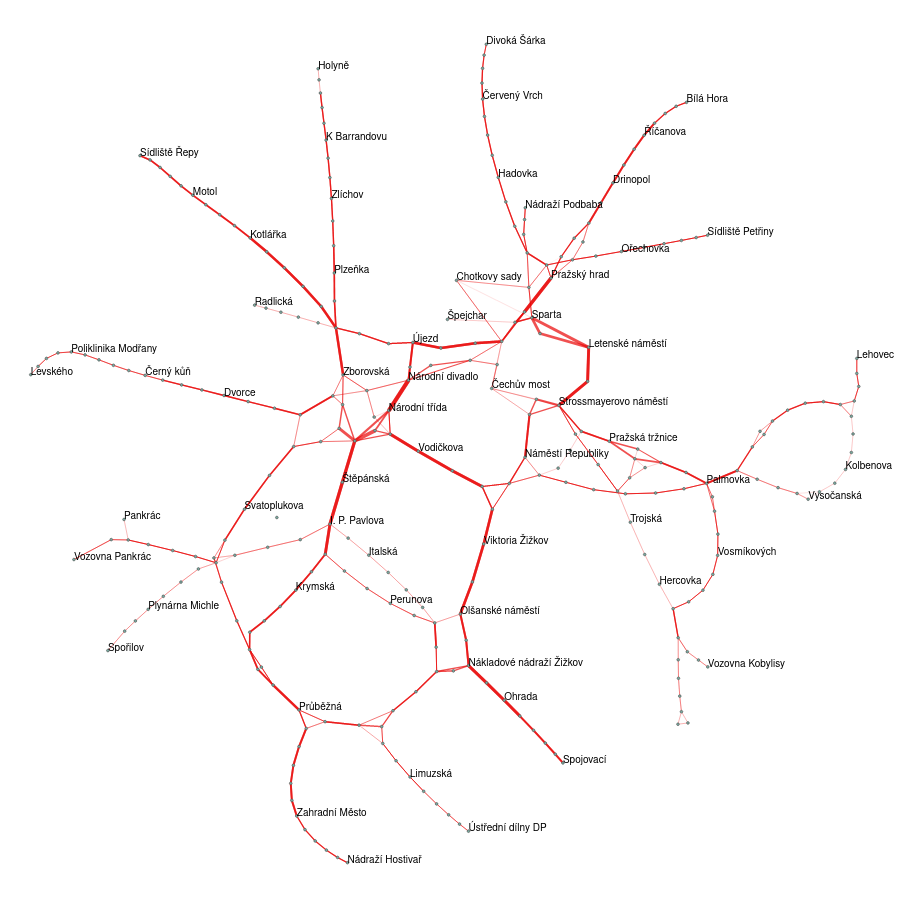

In [5]:
print(43*" " + "Prague Tram Network")
Image(filename='img/tram_network.png')

Jednotlivé vrcholy představují konkrétní stanice a tloušťka hran značí, kolik tramvají po dané trase v průběhu jednoho týdne projede. V grafu jsem zobrazil pouze některé názvy stanic a vynechal orientaci pro přehlednost. Velká většina spojů jezdí stejně oběma směry a šipky i moc názvů by graf udělaly nepřehledný.

### Míry centrality
Míry centrality již budu určovat na celém grafu. Vytvořím si proto graf v *networkx* stejným postupem jako výše, tentokrát ale nejen pro tramvaje, ale pro veškeré dostupné dopravní prostředky.

In [6]:
#variable so that I can see progress
progress = 0
print("Creating graph dictionary...")

#dict {(from_name, to_name) : weight}
graph_dict = dict()

for index, row in df.iterrows():
    key = (row["stop_from_name"], row["stop_to_name"])
    weight = row['monday'] + row['tuesday'] + row['wednesday'] + row['thursday'] + row['friday'] + row['saturday'] + row['sunday']
    if key not in graph_dict:
        graph_dict[key] = weight
    else:
        graph_dict[key] += weight

    progress += 1
    if progress % 100000 == 0:
        print(f"{progress} out of {df.shape[0]}")
        
print(f"Graph dictionary done. Size: {len(graph_dict)}")

# Create graph
G = nx.DiGraph()
for (from_name, to_name), val in graph_dict.items():
    G.add_edge(from_name, to_name, weight=val)

Creating graph dictionary...
100000 out of 1642433
200000 out of 1642433
300000 out of 1642433
400000 out of 1642433
500000 out of 1642433
600000 out of 1642433
700000 out of 1642433
800000 out of 1642433
900000 out of 1642433
1000000 out of 1642433
1100000 out of 1642433
1200000 out of 1642433
1300000 out of 1642433
1400000 out of 1642433
1500000 out of 1642433
1600000 out of 1642433
Graph dictionary done. Size: 18467


#### Degree centrality
Protože mám orientovaný graf, spočítám si vstupní, výstupní i celkovou stupňovou centralitu. Naštěstí *networkx* má na míry centrality funkce, takže jejich výpočet je jednoduchý.

,Degree centrality,In degree centrality,Out degree centrality
count,7396.000000,7396.000000,7396.000000
mean,4.993780,2.496890,2.496890
std,2.384526,1.212451,1.208653
min,1.000000,0.000000,0.000000
25%,4.000000,2.000000,2.000000
50%,4.000000,2.000000,2.000000
75%,6.000000,3.000000,3.000000
max,28.000000,14.000000,16.000000


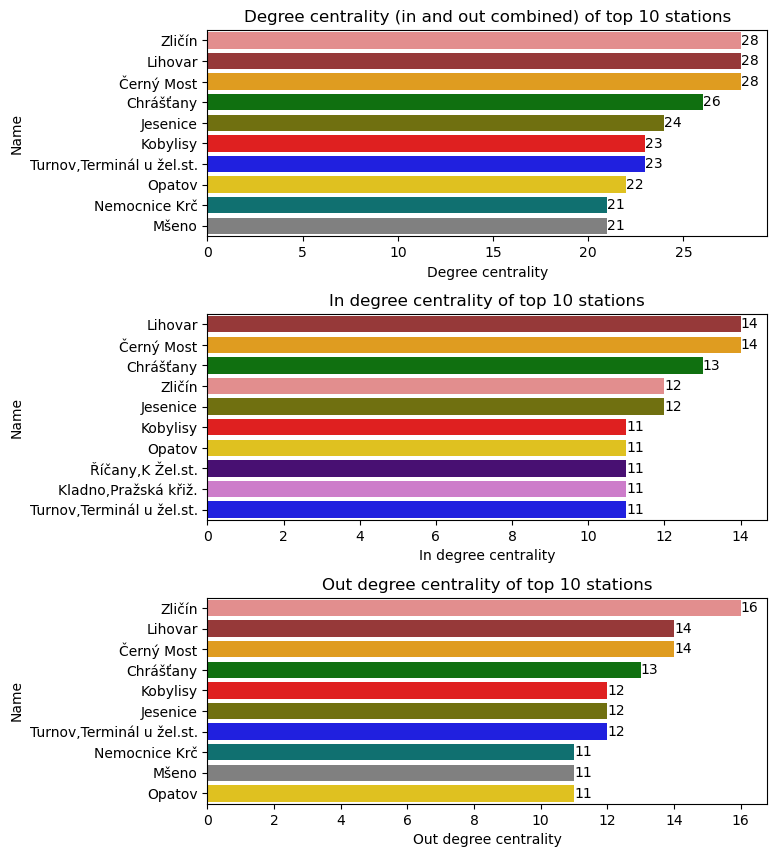

In [7]:
#compute degree centrality
in_cent_dict = nx.in_degree_centrality(G)
out_cent_dict = nx.out_degree_centrality(G)
cent_dict = nx.degree_centrality(G)

n = G.number_of_nodes()

def un_normalize(cent_dict, num):
    for key in cent_dict.keys():
        cent_dict[key] = int(np.round(cent_dict[key]*num))
    return None

#revert normalization
un_normalize(in_cent_dict, n)
un_normalize(out_cent_dict, n)
un_normalize(cent_dict, n)

#convert to dataframe
deg_df = pd.DataFrame.from_dict(cent_dict, orient='index', columns=['Degree centrality'])
in_deg_df = pd.DataFrame.from_dict(in_cent_dict, orient='index', columns=['In degree centrality'])
out_deg_df = pd.DataFrame.from_dict(out_cent_dict, orient='index', columns=['Out degree centrality'])
#join dataframes
deg_df = pd.concat([deg_df, in_deg_df, out_deg_df], axis=1)
#add names as column
deg_df.reset_index(inplace=True)
deg_df.rename(columns={"index" : "Name"}, inplace=True)

#define color pallete
pal = {
    "Zličín" : "lightcoral",
    "Lihovar" : "brown",
    "Černý Most" : "orange",
    "Chrášťany" : "green",
    "Jesenice" : "olive",
    "Turnov,Terminál u žel.st." : "blue",
    "Opatov" : "gold",
    "Nemocnice Krč" : "teal",
    "Mšeno" : "grey",
    "Říčany,K Žel.st." : "indigo",
    "Kladno,Pražská křiž." : "orchid",
    "Kobylisy" : "red" 
}

#plot stations with biggest degree centralities
fig, axes = plt.subplots(3, 1, figsize=(7,9))
fig.tight_layout(pad=3.5)

sns.barplot(x='Degree centrality',y='Name', data=deg_df.nlargest(10, 'Degree centrality'), ax=axes[0], palette=pal)
axes[0].set_title('Degree centrality (in and out combined) of top 10 stations')
axes[0].bar_label(axes[0].containers[0])

sns.barplot(x='In degree centrality',y='Name', data=deg_df.nlargest(10, 'In degree centrality'), ax=axes[1], palette=pal)
axes[1].set_title('In degree centrality of top 10 stations')
axes[1].bar_label(axes[1].containers[0])

sns.barplot(x='Out degree centrality',y='Name', data=deg_df.nlargest(10, 'Out degree centrality'), ax=axes[2], palette=pal)
axes[2].set_title('Out degree centrality of top 10 stations')
axes[2].bar_label(axes[2].containers[0])

#stats
display(deg_df.describe())
#display(deg_df.nlargest(10, 'Out degree centrality'))

Výstupní stupňová centralita nám vlastně říká, do kolika různých směrů jde z dané zastávky vyjet (kolik jiných zastávek s ní sousedí). Vstupní analogicky ukazuje, z kolika různých směrů je možné do dané zastávky přijet.
V průměru je vstupní i výstupní stupeň zastávek stejný a to  2.5. Zajímavé také je, že existují zastávky z kterých jde buď jenom odjet (vstupní stupeň je 0) nebo jenom do kterých jde jenom přijet (výstupní stupeň je 0). Zároveň ale neexistuje stanice, z které do které by nešlo ani přijet ani z ní odjet (minimální celkový stupeň je 1).

Z grafů je také patrné, že vstupní a výstupní stupeň se většinou výrazně neliší a stanice s výsokým vstupním stupněm mají často vysoký i výstupní stupeň.

#### Betweenness centrality

In [8]:
betw_dict = nx.betweenness_centrality(G)

,Betweenness centrality
count,7396.000000
mean,0.002659
std,0.006930
min,0.000000
25%,0.000270
50%,0.000864
75%,0.002437
max,0.181609


Text(0.5, 1.0, 'Betweenness centrality of top 15 stations')

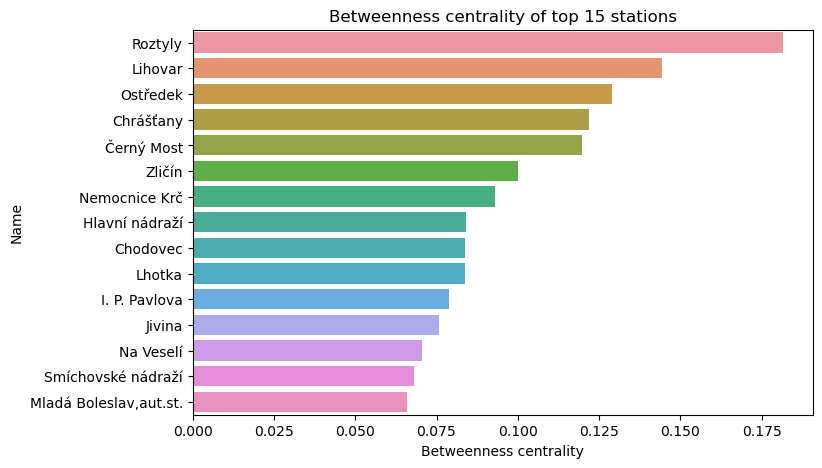

In [9]:
#transform to dataframe
betw_df = pd.DataFrame.from_dict(betw_dict, orient='index', columns=['Betweenness centrality'])
#add names as column
betw_df.reset_index(inplace=True)
betw_df.rename(columns={"index" : "Name"}, inplace=True)

display(betw_df.describe())

fig = plt.figure(figsize=(8, 5))
sns.barplot(x='Betweenness centrality',y='Name', data=betw_df.nlargest(15, 'Betweenness centrality')).set_title(
    'Betweenness centrality of top 15 stations'
)

*Betweenness centrality* neboli centralita mezilehlosti nám říká, jak často se konkrétní stanice vyskytuje na nejkratší cestě mezi nějakými jinými stanicemi. Zastávky s vyšší mírou mezilehlosti jsou tedy v jistém smyslu důležitější a bude přes ně nejspíše jezdit více lidí, protože jsou na nejkratší cestě mezi hodně jinými místy.

Z vizualizace výše lze pozorovat, že nejvyšší centralitu mezilehlosti mají suverénně Roztyly. Za nimi následuje Lihovar a pak Ostředek. Pokud bychom se chtěli dostat z nějakého místa A do místa B přes co nejmenší počet zastávek, je dost možné, že bychom přes nějakou z těchto zastávek jeli.

Také si můžeme všimnout, že centralita mezilehlosti asi bude do jisté míry souviset se stupňovou centralitou, protože plno zastávek s vysoukou centralitou mezilehlosti mělo vysokou i stupňovou centralitu.

Je důležité si ale uvědomit, že zde analyzuji nejkratší cestu na základě nejmenšího počtu zastávek, ne času.

#### Closeness centrality

In [10]:
close_dict_all = nx.closeness_centrality(G)

,Closeness centrality
count,7396.000000
mean,0.049689
std,0.008873
min,0.000000
25%,0.044355
50%,0.050408
75%,0.055846
max,0.075022


Text(0.5, 1.0, 'Closeness centrality of top 20 stations')

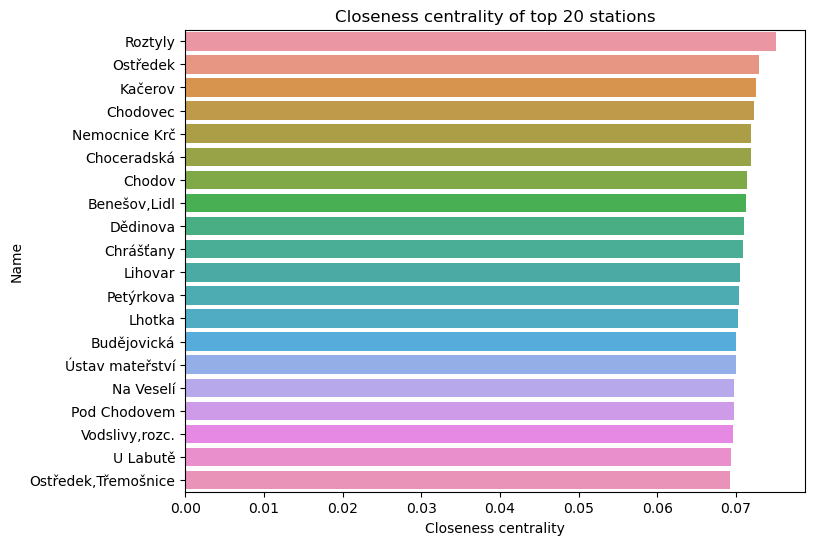

In [11]:
#transform to dataframe
close_df = pd.DataFrame.from_dict(close_dict_all, orient='index', columns=['Closeness centrality'])
#add names as column
close_df.reset_index(inplace=True)
close_df.rename(columns={"index" : "Name"}, inplace=True)

display(close_df.describe())

fig = plt.figure(figsize=(8, 6))
sns.barplot(x='Closeness centrality',y='Name', data=close_df.nlargest(20, 'Closeness centrality')).set_title(
    'Closeness centrality of top 20 stations'
)

Centralitu blízkosti mají opět nejvyšší Roztyly. Tato míra centrality vypovídá o tom, jak moc jsou jednotlivé vrcholy vzdáleny od všech ostatních. V našem případě tedy počet zastávek na nejkratší cestě od všech ostatních. Čím má daná stanice nižší průměrný počet stanic na nejkratší cestě ke všem ostatním, tím je důležitější.

Z dat výše je vidět, že jednotlivé zastávky mají celkem podobné hodnoty. To znamená, že síť městské dopravy je dobře propojená a mezi skoro každými dvěma místy se lze dostat pomocí podobně velkého počtu zastávek. Samozřejmě zastávky na kraji sítě budou mít nižší hodnoty než uprostřed, ale z kvartilů je i tak vidět, že mezikvartilové rozpětí je celkem úzké.

### Vlastní otázky

#### Dokážu se pomocí nočních tramvají dostat na každou tramvajovou zastávku?

In [12]:
#ONLY TRAM

#dict {(from_name, to_name) : weight}
progress = 0
graph_dict_tram = dict()
print("Creating graph dictionary for tram...") #note for self
#go through all rows
for index, row in df.iterrows():
    progress += 1
    if progress % 100000 == 0:
        print(f"{progress} out of {df.shape[0]}")
        
    #skip other means of transport and day connections.
    if row["route_type"] != 0 or row["is_night"] != 1:
        continue;
        
    key = (row["stop_from_name"], row["stop_to_name"])
    #number of times that this connection rides over whole week
    weight = row['monday'] + row['tuesday'] + row['wednesday'] + row['thursday'] + row['friday'] + row['saturday'] + row['sunday']
    #if this pair of stations is new, add it to the dictionary
    if key not in graph_dict_tram:
        graph_dict_tram[key] = weight
    #else add weight to the existing
    else:
        graph_dict_tram[key] += weight

print(f"Graph dictionary done. Size: {len(graph_dict_tram)}")

# Create tram graph
N = nx.DiGraph()
for (from_name, to_name), val in graph_dict_tram.items():
    N.add_edge(from_name, to_name, weight=val)

Creating graph dictionary for tram...
100000 out of 1642433
200000 out of 1642433
300000 out of 1642433
400000 out of 1642433
500000 out of 1642433
600000 out of 1642433
700000 out of 1642433
800000 out of 1642433
900000 out of 1642433
1000000 out of 1642433
1100000 out of 1642433
1200000 out of 1642433
1300000 out of 1642433
1400000 out of 1642433
1500000 out of 1642433
1600000 out of 1642433
Graph dictionary done. Size: 550


In [13]:
#assign groups to verticies

# Add group for nodes conected by night trams
for n, data in N.nodes(data=True):
    data['group'] = 1
    
for index, row in df.iterrows():
    if row["route_type"] != 0:
        continue;
    # Add nodes that arent accesible by night trams to second group
    if not N.has_node(row["stop_from_name"]):
        N.add_node(row["stop_from_name"], group=2)
    if not N.has_node(row["stop_to_name"]):
        N.add_node(row["stop_to_name"], group=2)

In [14]:
"""
try:
    network, config = nw.visualize(N, plot_in_cell_below=False)
except (BrokenPipeError, FileNotFoundError):
    pass
"""

'\ntry:\n    network, config = nw.visualize(N, plot_in_cell_below=False)\nexcept (BrokenPipeError, FileNotFoundError):\n    pass\n'

                                        Night Prague Tram Network


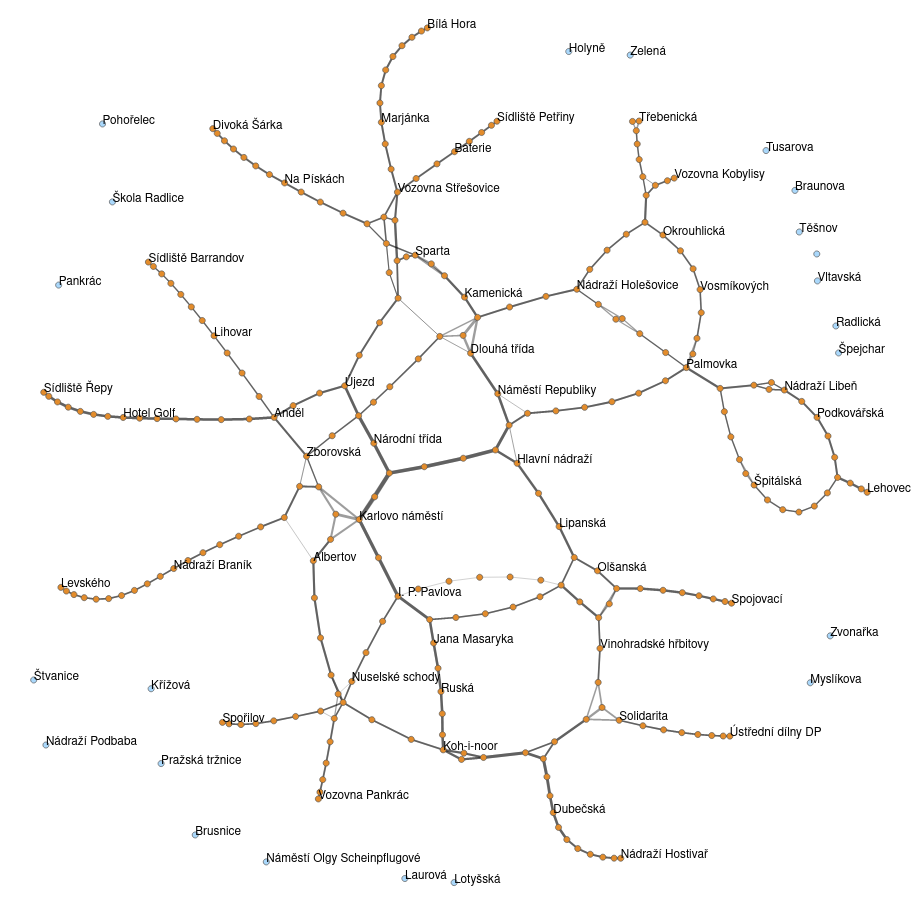

In [15]:
print(40*" " + "Night Prague Tram Network")
Image(filename='img/night_tram_network.png')

Vykreslil jsem si síť nočních tramvají. Na první pohled vypadá dost podobně jako síť pro denní tramvaje, ale je míň hustě propojená. Mezi jednotlivými stanicemi neexistuje tolik cest jako u denních tramvají a některé zastávky nejsou propojené vůbec. V grafu jsem je znázornil modře a znamená to, že do nich ani z nich nejede během noci jediná tramvaj.

Aby nedošlo ke zmatení tak ještě uvádím, že tloušťku hran jsem si upravil tak, aby byly vidět i spoje, které během noci projedou třeba pouze jednou. To, že jsou hrany stejně tlusté jako na grafu pro denní tramvaje neznamená, že zde jezdí stejný počet tramvají.

#### Je možné tramvaje kompletně nahradit ostatními dopravními prostředky?
Zkusím si vykreslit graf, ve kterém budou vrcholy představovat tramvajové zastávky, ale hrany mezi nimi budou ostatní dopravní prostředky.

In [16]:
stations = set(T.nodes())

#Edges other than from trams

#dict {(from_name, to_name) : weight}
progress = 0
graph_dict_tram = dict()
print("Creating graph dictionary for tram...") #note for self

#go through all rows
for index, row in df.iterrows():
    
    progress += 1
    if progress % 100000 == 0:
        print(f"{progress} out of {df.shape[0]}")
        
    #skip if tram or station does not belong to tram
    if row["route_type"] == 0 or row["stop_from_name"] not in stations or row["stop_to_name"] not in stations:
        continue;
        
    key = (row["stop_from_name"], row["stop_to_name"])
    #number of times that this connection rides over whole week
    weight = row['monday'] + row['tuesday'] + row['wednesday'] + row['thursday'] + row['friday'] + row['saturday'] + row['sunday']
    #if this pair of stations is new, add it to the dictionary
    if key not in graph_dict_tram:
        graph_dict_tram[key] = weight
    #else add weight to the existing
    else:
        graph_dict_tram[key] += weight

print(f"Graph dictionary done. Size: {len(graph_dict_tram)}")

# Create tram graph
U = nx.DiGraph()
for (from_name, to_name), val in graph_dict_tram.items():
    U.add_edge(from_name, to_name, weight=val)

Creating graph dictionary for tram...
100000 out of 1642433
200000 out of 1642433
300000 out of 1642433
400000 out of 1642433
500000 out of 1642433
600000 out of 1642433
700000 out of 1642433
800000 out of 1642433
900000 out of 1642433
1000000 out of 1642433
1100000 out of 1642433
1200000 out of 1642433
1300000 out of 1642433
1400000 out of 1642433
1500000 out of 1642433
1600000 out of 1642433
Graph dictionary done. Size: 335


In [17]:
"""
try:
    network, config = nw.visualize(U, plot_in_cell_below=False)
except (BrokenPipeError, FileNotFoundError):
    pass
"""

'\ntry:\n    network, config = nw.visualize(U, plot_in_cell_below=False)\nexcept (BrokenPipeError, FileNotFoundError):\n    pass\n'

                          Network of Prague tram stations connected without trams


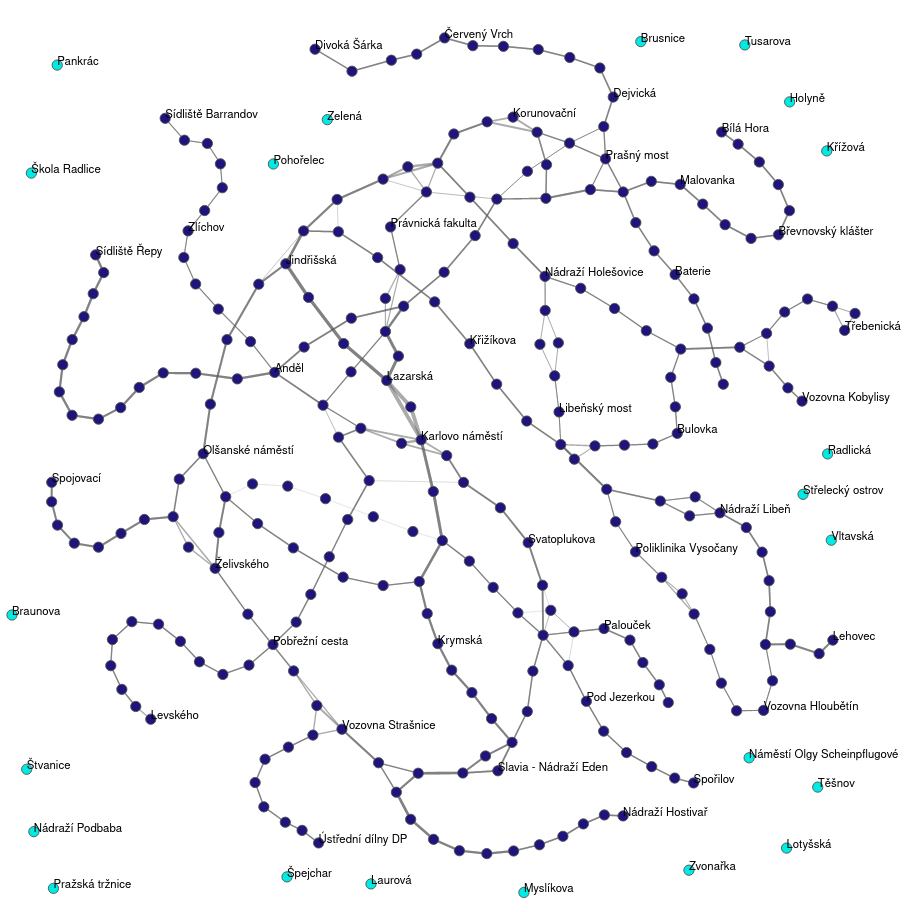

In [18]:
print(26*" " + "Network of Prague tram stations connected without trams")
Image(filename='img/network_without_tram.png')

Kupodivu je síť pražských tramvajových zastávek propojena celkem hustě i bez tramvají. Existuje plno výjimek, na které se bez tramvají nedostaneme, ale mezi velkou většinou tramvajových stanic se lze pohybovat i bez použití tramvají.

#### Jsou tramvajové zastávky u metra více vytížené, než zastávky, které u metra neleží?

In [19]:
# modify existing tramp graph
# change group of subway stations to other color

subway_dict = dict()

# Add group for tram 
for n, data in T.nodes(data=True):
    data['group'] = 1
    
for index, row in df.iterrows():
    #skip if not subway
    if row["route_type"] != 1:
        continue;
        
    if T.has_node(row["stop_from_name"]):
        nx.set_node_attributes(T, {row["stop_from_name"] : {"group": 2}})
        
    if T.has_node(row["stop_to_name"]):
        nx.set_node_attributes(T, {row["stop_to_name"] : {"group": 2}})
    

In [20]:
"""
try:
    network, config = nw.visualize(T, plot_in_cell_below=False)
except (BrokenPipeError, FileNotFoundError):
    pass
"""

'\ntry:\n    network, config = nw.visualize(T, plot_in_cell_below=False)\nexcept (BrokenPipeError, FileNotFoundError):\n    pass\n'

                       Network of Prague tram stations with highlighted subway stations


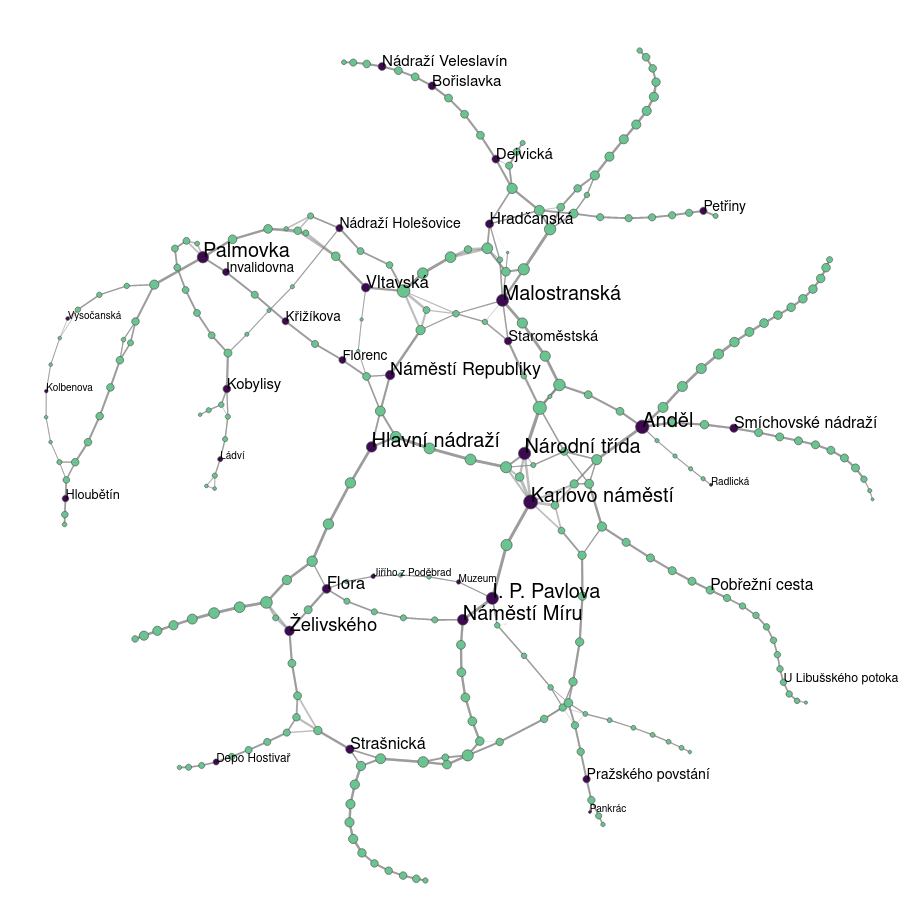

In [21]:
print(23*" " + "Network of Prague tram stations with highlighted subway stations")
Image(filename='img/subway_tram_network.png')

Zobrazil jsem si síť tramvajových zastávek a zastávky, které jsou zároveň zastávky metra, jsem zvýraznil fialově. Velikost jednotlivých vrcholů odpovídá vytíženosti konkrétních stanic.

Lze si všimnout, že stanice metra v centru sítě jsou sice vytíženějsí než ostatní, ale to je tím že leží v centru. Pokud se podíváme na vrcholy metra na okrajích, je vidět, že jsou stejně malé jako ostatní, u kterých metro není. Přítomnost metra na tramvajové zastávce tedy nutně neznamená, že tam bude jezdit více tramvají.